# ROI analysis: Results
Natalia Vélez, April 2022

In [1]:
%matplotlib inline

import sys, pickle
import pandas as pd
import numpy as np
from os.path import join as opj

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

sys.path.append('..')
from utils import gsearch, print_list, str_extract
import rsatoolbox as rsa

in_dir = 'outputs/roi_rsa'

Get IDs of valid participants

In [2]:
subjects = np.loadtxt('../1_preprocessing/outputs/valid_participants.txt', dtype=int)
print(subjects)

[ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26
 27 28 29 30]


In [3]:
corr_list = []

for s in subjects:
    sub_id = f'sub-{s:02}'

    # Load behavioral RDMs
    behav_file = opj(in_dir, sub_id, f'{sub_id}_behavioral_RDM.p')
    with open(behav_file, 'rb') as f:
        behav_dict = pickle.load(f)

    # Load neuro RDMs
    neuro_files = gsearch(in_dir, sub_id, '*RDM.h5')

    # Compute Spearman correlation between each behavioral and neural rDM
    for behav_label, behav_model in behav_dict.items():
        behav_rdm = behav_model.predict_rdm() # Load behav RDM

        for roi_file in neuro_files:
            roi_label = str_extract('(?<=roi-)[A-Z]+', roi_file)
            roi_rdm = rsa.rdm.load_rdm(roi_file) # Load neuro RDM

            # Compare using Spearman correlation
            corr = rsa.rdm.compare_spearman(behav_rdm, roi_rdm)

            corr_list.append((sub_id, roi_label, behav_label, corr[0][0]))

In [4]:
corr_df = pd.DataFrame(corr_list, columns=['subject', 'roi', 'model', 'r'])
corr_df['z'] = np.arctanh(corr_df.r)

print(corr_df.shape)
corr_df.head()

(582, 5)


,subject,roi,model,r,z
0,sub-01,DMPFC,belief,-0.003265,-0.003265
1,sub-01,LTPJ,belief,0.005088,0.005088
2,sub-01,MMPFC,belief,-0.004807,-0.004807
3,sub-01,PC,belief,-0.032646,-0.032658
4,sub-01,RSTS,belief,0.036715,0.036731


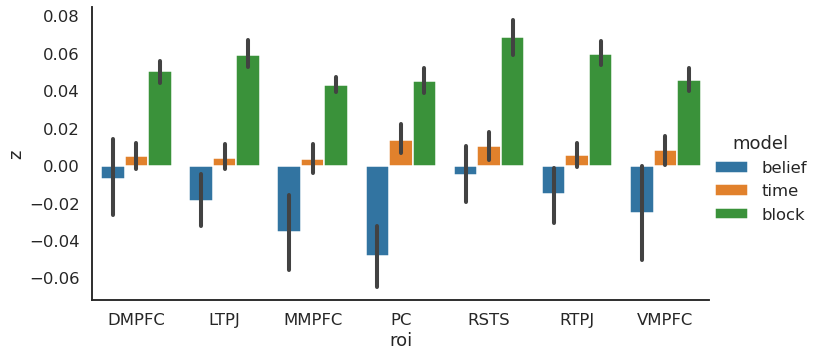

In [5]:
sns.catplot(data=corr_df, x='roi', y='z', hue='model', kind='bar', aspect=2)